In [435]:
import numpy as np
from itertools import product
from random import random
from matplotlib import pyplot as plt

In [15]:
CIRCLE = 2
CROSS = 1
EMPTY = 0

In [595]:
all_possible_states = np.array(
    list(product(*([[EMPTY, CROSS, CIRCLE]] * 9)))
).reshape((-1, 3, 3))
all_possible_states.shape

(19683, 3, 3)

In [25]:
all_possible_states[:4], all_possible_states[-1]

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 1]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 2]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]),
 array([[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]))

In [71]:
def get_state_index(state):
    return np.argwhere((all_possible_states[:] == state).reshape((-1,9)).all(axis=-1)).flatten()[0]

In [63]:
def get_transitions_states(state, figure):
    next_states = []
    for plase in np.argwhere(state == EMPTY):
        s = state.copy()
        s[tuple(plase)] = figure
        next_states.append(s)
    return next_states

def get_transitions_dict(figure):
    return {
        i: [
            get_state_index(s) for s in get_transitions_states(state, figure)
        ]
        for i, state in enumerate(all_possible_states)
    }

In [72]:
crosses_transitions = get_transitions_dict(CROSS)
crosses_transitions[0]

[6561, 2187, 729, 243, 81, 27, 9, 3, 1]

In [75]:
circles_transitions = get_transitions_dict(CIRCLE)

In [76]:
with open('crosses_transitions.txt', 'w') as f:
    f.write(repr(crosses_transitions))

with open('circles_transitions.txt', 'w') as f:
    f.write(repr(circles_transitions))

In [527]:
ALPHA = 0.002
RANDOM_MOVE_POSSIBILITY = 0.1

In [528]:
class Actor():
    
    def __init__(self, is_circles, lr=None, random_possibility=None):
        self.is_circles = is_circles
        self.states = []
        self.figure = CIRCLE if self.is_circles else CROSS
        self.transitions = circles_transitions if self.is_circles else crosses_transitions
        self.set_default_costs()
        self.is_learning = True
        self.previous_selected_state = None
        self.lr = lr if lr is not None else ALPHA
        self.random_possibility = (
            random_possibility if random_possibility is not None else RANDOM_MOVE_POSSIBILITY
        )

    def reset_state(self):
        self.previous_selected_state = None
        
    def get_next_state(self, state_index, random_possible=True):
        next_states = self.transitions[state_index]
        if len(next_states) == 0:
            # Если все поле уже заполнено
            return None
        next_state = None
        if random_possible and random() < RANDOM_MOVE_POSSIBILITY:
            next_state = np.random.choice(next_states)
        else:
            states_cost = np.array([
                self.costs[s] for s in next_states
            ])
            next_state = next_states[np.random.choice(
                np.argwhere(states_cost == max(states_cost)).flatten()
            )]
        if self.is_learning and self.previous_selected_state is not None:
            self.costs[self.previous_selected_state] += (
                self.lr * (self.costs[next_state] - self.costs[self.previous_selected_state])
            )

        self.previous_selected_state = next_state
        return next_state

    def set_default_costs(self):
        self.costs = np.full((all_possible_states.shape[0]), 0.5)
        for i, state in enumerate(all_possible_states):
            if self.is_win(state):
                self.costs[i] = 1.
        self.win_states = np.argwhere(self.costs == 1.).flatten()

    def is_win(self, state_matrix):
        for row in state_matrix:
            if (row == self.figure).all():
                return True
        for column in state_matrix.transpose():
            if (column == self.figure).all():
                return True
        if ((state_matrix.diagonal() == self.figure).all() or
            (np.fliplr(state_matrix).diagonal() == self.figure).all()):
            return True
        

In [529]:
def train_match(actor_1, actor_2):
    state_index = 0
    actor_1.reset_state()
    actor_2.reset_state()
    while True:
        state_index = actor_1.get_next_state(state_index)
        if state_index in actor_1.win_states:
            # Остановка если победил первый игрок
            return 0
        state_index = actor_2.get_next_state(state_index)
        if state_index is None:
            # Остановка если ничья
            return -1
        if state_index in actor_2.win_states:
            # Остановка если победил второй игрок
            return 1

In [606]:
circles = Actor(True)
crosses = Actor(False)

In [607]:
results = {
    -1: 0,
    0: 0,
    1: 0
}
for i in range(5*10**4):
    winner = train_match(crosses, circles)
    results[winner] += 1
results    

{-1: 743, 0: 37791, 1: 11466}

In [568]:
{i: val/(sum(results.values())) for i, val in results.items()}

{-1: 0.0232, 0: 0.2786, 1: 0.6982}

In [608]:
np.save('circles_costs.npy', circles.costs)
np.save('crosses_costs.npy', crosses.costs)

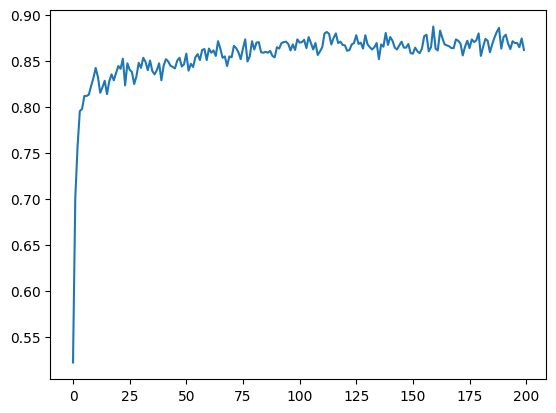

In [569]:
actors_count = 100
crosses_new = [Actor(False) for _ in range(actors_count)]
scores = []
scores_tries = 20
circles.is_learning = False
for i in range(2*10**3):
    if i % 10 == 0:
        count = 0
        for c in crosses_new:
            c.is_learning = False
            for _ in range(scores_tries):
                winner = train_match(c, circles)
                if winner == 0:
                    count += 1
            c.is_learning = True
        scores.append(count/(scores_tries * actors_count))
    for c in crosses_new:
        winner = train_match(c, circles)
    
plt.plot(scores)

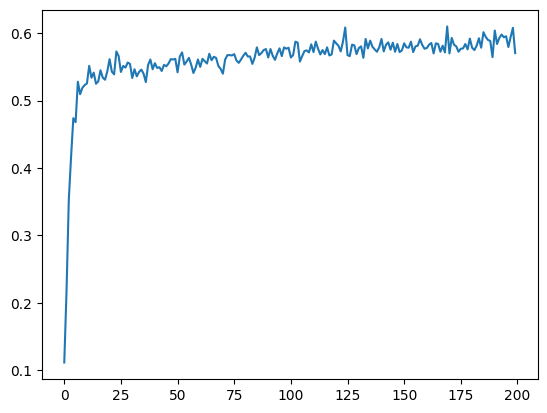

In [570]:
actors_count = 100
circles_new = [Actor(True) for _ in range(actors_count)]
scores = []
scores_tries = 20
crosses.is_learning = False
for i in range(2*10**3):
    if i % 10 == 0:
        count = 0
        for c in circles_new:
            c.is_learning = False
            for _ in range(scores_tries):
                winner = train_match(crosses, c)
                if winner == 1:
                    count += 1
            c.is_learning = True
        scores.append(count/(scores_tries * actors_count))
    for c in circles_new:
        winner = train_match(crosses, c)
    
plt.plot(scores)